In [1]:
import torch
import matplotlib.pyplot as plt
from skripsi_program import (
    Burgers,
    FourierBasis,
    to_complex_coeff,
    to_real_coeff,
    StandardScaler,
    SpectralSVR,
    Basis,
    LSSVR,
    get_metrics,
)
from notebooks.utils import save_to_pgf
import pandas as pd

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
        "figure.constrained_layout.use": True,
    }
)

In [3]:
time_domain = slice(0, 10, 2000)
space_domain = slice(0, 2, 400)
periods = (time_domain.stop - time_domain.start, space_domain.stop - space_domain.start)
problem = Burgers()

def get_input_output(u: Basis, f: Basis, time_res: slice):
    # get values at time resolution
    spatial_modes = u.to_time_dependent().modes[0]
    spatial_res = slice(0, u.periods[1], spatial_modes)
    res = (time_res, spatial_res)

    u_val = u.get_values(res=res)
    f_val = f.get_values(res=res)
    # get the coefficients at the time resolution
    u_coeff = u.transform(u_val.flatten(0, 1)).unflatten(0, u_val.shape[:2])
    f_coeff = u.transform(f_val.flatten(0, 1)).unflatten(0, f_val.shape[:2])
    # merge sample and time dimension
    # future time step diff
    un = (u_coeff[:, 1:] - u_coeff[:, :-1]).flatten(0, 1)
    # current time step
    uc = u_coeff[:, :-1].flatten(0, 1)
    fc = f_coeff[:, 1:].flatten(0, 1)
    # merge all spatial coefficient dimensions and convert to real valued coefficients
    uc_flat = to_real_coeff(uc.flatten(1))
    fc_flat = to_real_coeff(fc.flatten(1))
    x = torch.concat((uc_flat, fc_flat), dim=1)
    y = to_real_coeff(un.flatten(1))
    return x, y

In [4]:
grid_res = (time_domain, slice(space_domain.start, space_domain.stop, 200))
grid = FourierBasis.grid(res=grid_res)
dt = grid[1, 0, 0] - grid[0, 0, 0]
dx = grid[0, 1, 1] - grid[0, 0, 1]
c = 2.0

def u_exact(x: torch.Tensor, t: torch.Tensor, nu: float = 0.01, c: float = 2.0):
    # use p. 705-706 Partial Differential Equations and Solitary Waves Theory, Abdul-Majid Wazwaz
    # eq 1.5 doi: 10.1090/QAM/306736
    # doi: 10.1002/cnm.850
    pi = torch.pi
    pi_x = pi * x
    u = (2 * nu * pi * pi_x.sin()) / (c * t.mul(pi**2 * nu).exp() + pi_x.cos())
    return u

extent = (
    grid[0, 0, 1].item(),
    grid[0, -1, 1].item(),
    grid[0, 0, 0].item(),
    grid[-1, 0, 0].item(),
)
xlim = (
    grid[0, 0, 1].item(),
    grid[0, -1, 1].item(),
)
ylim = (
    grid[0, 0, 0].item(),
    grid[-1, 0, 0].item(),
)

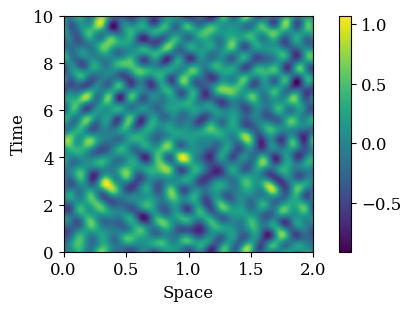

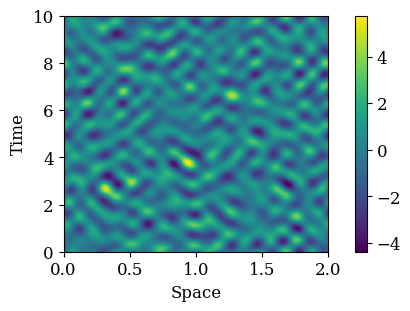

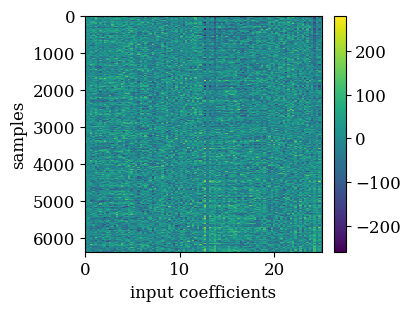

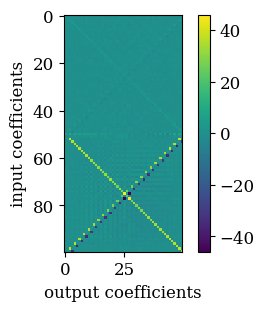

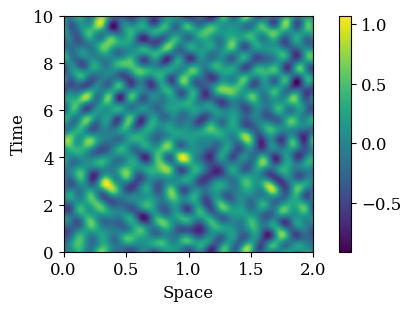

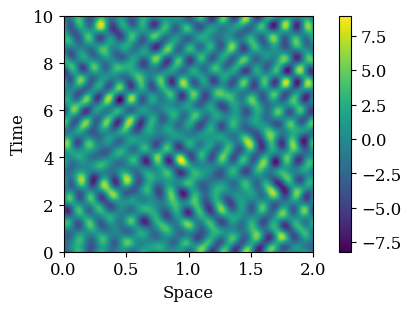

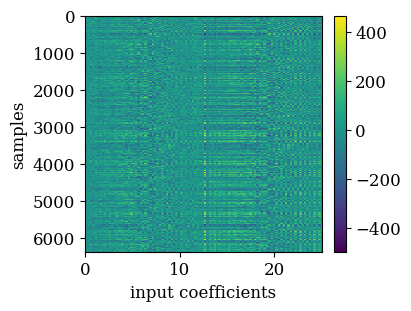

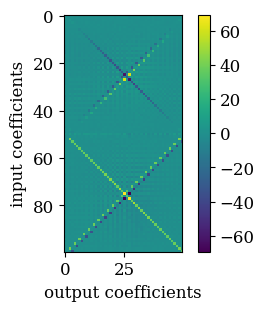

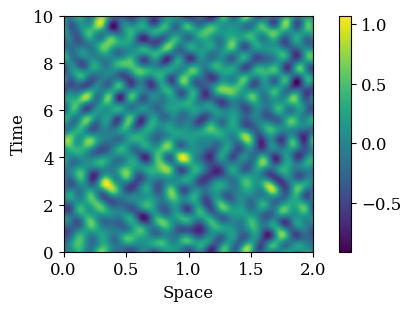

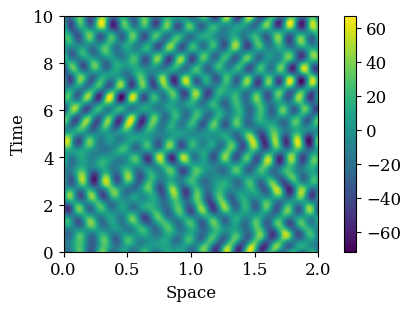

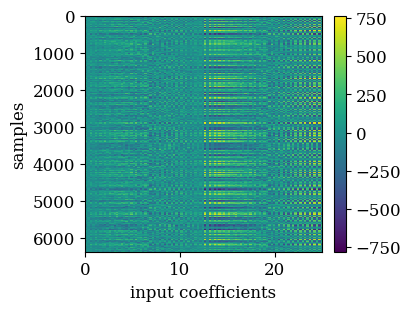

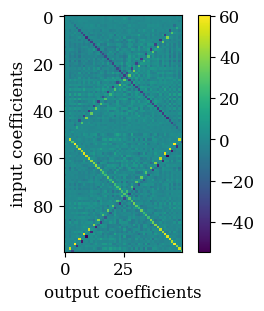

In [5]:
nu_values = [0.0, 0.01, 0.1]
n = 40
modes = (25,)
nt = 200
time_res = slice(time_domain.start, time_domain.stop, nt)
space_period = space_domain.stop - space_domain.start
data_metrics = {}
spectral_results = {}
function_results = {}
sigma_values = {}
data_fig = []
data_ax = []
interp_fig = []
interp_ax = []
for i, nu in enumerate(nu_values):
    generator = torch.Generator().manual_seed(42)
    u_rand, f_rand = problem.generate(
        basis=FourierBasis,
        n=n,
        modes=modes,
        nu=nu,
        u0="random",
        f="random",
        generator=generator,
        time_domain=time_domain,
        space_domain=space_domain,
        time_dependent_coeff=False,
    )

    # add noise
    u_5 = u_rand.perturb(std_ratio=0.05, generator=generator)
    f_5 = f_rand.perturb(std_ratio=0.05, generator=generator)

    fig, ax = plt.subplots(figsize=(4, 3))
    im = u_5.plot(i=0, plt=ax)
    fig.colorbar(im, ax=ax)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    data_fig.append(fig)
    data_ax.append(ax)
    save_to_pgf(f"burgers_solution_{nu}.pgf", plt=fig)

    fig, ax = plt.subplots(figsize=(4, 3))
    im = f_5.plot(i=0, plt=ax)
    fig.colorbar(im, ax=ax)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    data_fig.append(fig)
    data_ax.append(ax)
    save_to_pgf(f"burgers_forcing_{nu}.pgf", plt=fig)

    # Split data by function sample
    n_train = int(0.8 * n)
    x_train, y_train = get_input_output(u_5[:n_train], f_5[:n_train], time_res=time_res)
    x_test, y_test = get_input_output(u_5[n_train:], f_5[n_train:], time_res=time_res)
    # scale input data
    scaler = StandardScaler().fit(x_train)
    input_train = scaler.transform(x_train)
    input_test = scaler.transform(x_test)
    output_train = y_train
    output_test = y_test

    previous_time_step = to_real_coeff(x_train[:, : y_train.shape[1]]).contiguous()
    next_time_step = to_real_coeff(y_train[:]).contiguous()
    nu_label = f"{nu}"
    data_metrics = {
        **data_metrics,
        nu_label: get_metrics(next_time_step, previous_time_step),
    }

    # Training
    model = SpectralSVR(
        FourierBasis(periods=space_period),
        svr=LSSVR(C=1.0),
    )
    model.train(input_train, output_train)
    sigma_values = {**sigma_values, nu_label: model.svr.kernel_params["sigma"].item()}
    # Testing
    test_metrics = model.test(input_test, output_test)
    spectral_results = {
        **spectral_results,
        nu_label: {
            **test_metrics["spectral"],
        },
    }
    function_results = {
        **function_results,
        nu_label: {
            **test_metrics["function value"],
        },
    }
    # # Exact testing
    # u_val = u_exact(grid[..., 1], grid[..., 0], nu=nu, c=c)
    # plt.imshow(
    #     u_val, extent=extent, origin="lower", aspect="auto", interpolation="none"
    # )
    # plt.xlim(*xlim)
    # plt.ylim(*ylim)
    # plt.colorbar()
    # exact_coeff = FourierBasis.transform(u_val)
    # u_e = FourierBasis(exact_coeff.unsqueeze(0), time_dependent=True, periods=periods)
    # f_e = FourierBasis(
    #     FourierBasis.generate_empty(1, exact_coeff.shape),
    #     time_dependent=True,
    #     periods=periods,
    # )
    # interpretation
    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i
    corr = model.svr.get_correlation_image().cpu()
    sorted = output_train.real[:, 4].sort()
    im = interp_ax[fig_index].imshow(
        corr[sorted.indices.cpu(), :],
        interpolation="none",
        aspect="auto",
        extent=(0, modes[0], corr.shape[0], 0),
    )
    interp_ax[fig_index].set_ylabel("samples")
    interp_ax[fig_index].set_xlabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[fig_index])
    save_to_pgf(f"burgers_ci_{nu}.pgf", plt=interp_fig[fig_index])
    # corr_image = model.svr.get_correlation_image()
    # plt.figure(figsize=(10, 10))
    # plt.imshow(corr_image, aspect="auto")
    # plt.colorbar()

    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i + 1
    p_mat = model.svr.get_p_matrix().cpu()
    im = interp_ax[fig_index].imshow(p_mat[:, :], interpolation="none", aspect="equal")
    interp_ax[fig_index].set_xlabel("output coefficients")
    interp_ax[fig_index].set_ylabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[2 * i + 1])
    save_to_pgf(f"burgers_pm_{nu}.pgf", plt=interp_fig[fig_index])
    # p_matrix = model.svr.get_p_matrix()
    # plt.figure(figsize=(10, 10))
    # plt.imshow(p_matrix, aspect="auto")
    # plt.colorbar()

In [6]:
sigma_values

{'0.0': 10.000785827636719,
 '0.01': 10.000785827636719,
 '0.1': 10.000784873962402}

In [1]:
data_results_df = pd.DataFrame(data_metrics).T
data_results_df.index.name="\(\nu\)"
data_results_df.style.format(precision=2).to_latex("tmp.tex")

NameError: name 'pd' is not defined

In [12]:
spectral_results_df = pd.DataFrame(spectral_results).T
spectral_results_df.index.name="\(\nu\)"
spectral_results_df.style.format(precision=2).to_latex("tmp.tex")

In [15]:
function_results_df = pd.DataFrame(function_results).T
function_results_df.index.name = "\(\nu\)"
function_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)